In [1]:
# Histograms for interphase vs. mitotic matched datasets. To run this notebook
# one needs to run the package variance-paper-reply* first.
#
# *needs renaming it after paper resubmission: suggested name cvapipe_mapping

In [2]:
!date
!pwd

Mon Feb 28 21:10:36 PST 2022
/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/FigureMitosis


In [1]:
import os
import sys
import importlib
import concurrent
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from skimage import io as skio
import matplotlib.pyplot as plt
from aicscytoparam import cytoparam
from aicsshparam import shtools, shparam
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter
from cvapipe_analysis.tools import io, viz, general, controller, shapespace, plotting

sys.path.insert(1, '../tools')
import common

In [2]:
# Controller form cvapipe_analysis
path_config = Path("/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/")
control = controller.Controller(general.load_config_file(path_config))
device = io.LocalStagingIO(control)
df = device.load_step_manifest("preprocessing")
print(df.shape, control.get_staging())

(202847, 1290) /allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_variance


In [5]:
space = shapespace.ShapeSpace(control)
space.execute(df)

In [6]:
path_cvapipe = Path(control.get_staging()).parent
datasets = {
    "M1M2": {
        "control": f"{path_cvapipe}/local_staging_variance_m1m2",
        "perturbed": f"{path_cvapipe}/local_staging_m1m2"
    },
    "M3": {
        "control": f"{path_cvapipe}/local_staging_variance_m3",
        "perturbed": f"{path_cvapipe}/local_staging_m3"
    }}

In [7]:
smapper = shapespace.ShapeSpaceMapper(space, output_folder="./")
smapper.use_full_base_dataset()
smapper.set_make_plots_off()
smapper.set_distance_threshold(1e10)
smapper.map(datasets)

	M1M2 loaded. (2201, 1255)
	M3 loaded. (981, 1255)


In [8]:
importlib.reload(plotting)

<module 'cvapipe_analysis.tools.plotting' from '/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/cvapipe_analysis/tools/plotting.py'>

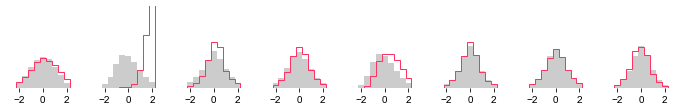

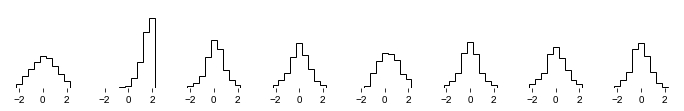

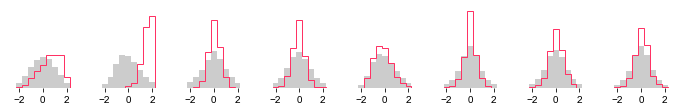

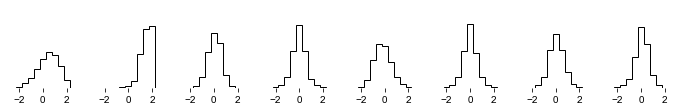

In [9]:
pmaker = plotting.ShapeSpaceMapperPlotMaker(control, "./")
pmaker.set_dataframe(smapper.result)
pmaker.plot_mapping_1d(display_both=False)

In [44]:
for fig, desc in pmaker.figs:
    fig.savefig(f"hists_{desc}.pdf")

### Reconstruct shapes of individual and matched datasets

In [12]:
instances = {}
# Loop over all cells, edge cells and cells from shape matched dataset
for dsname in datasets.keys():
    instances[dsname] = []
    for prefix, suffix in zip(["base", dsname, dsname], ["", "", "_base_matched"]):
        nisos = control.get_number_of_interpolating_points()
        inner_alias = control.get_inner_most_alias_to_parameterize()
        fname = f"avgshape/{prefix}_{inner_alias}{suffix}.vtk"
        inner_mesh = device.read_vtk_polydata(fname)
        outer_alias = control.get_outer_most_alias_to_parameterize()
        fname = f"avgshape/{prefix}_{outer_alias}{suffix}.vtk"
        outer_mesh = device.read_vtk_polydata(fname)
        domain, _ = cytoparam.voxelize_meshes([outer_mesh, inner_mesh])

        domain_nuc = (255*(domain>1)).astype(np.uint8)
        domain_mem = (255*(domain>0)).astype(np.uint8)

        instances[dsname].append(np.stack([domain_nuc, domain_mem, domain_mem], axis=0))

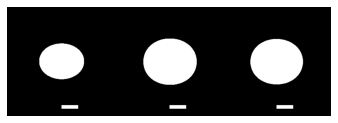

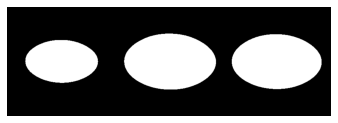

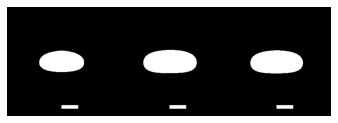

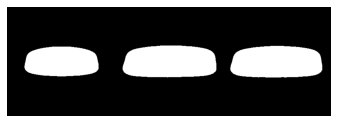

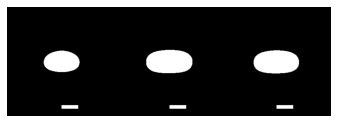

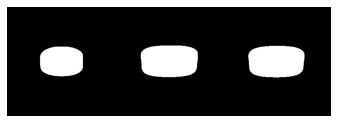

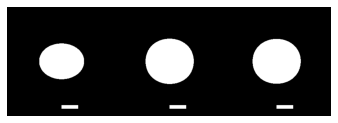

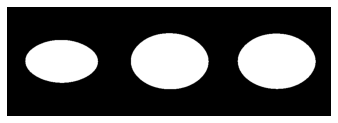

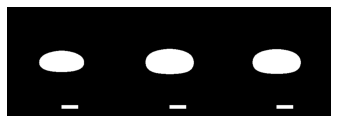

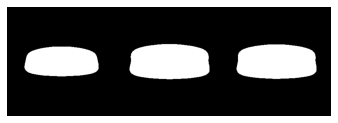

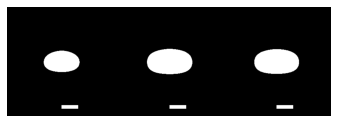

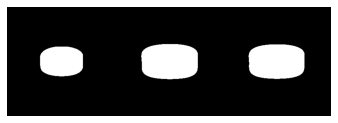

In [15]:
mode = {
    "nuc": "center_nuc",
    "mem": "center_nuc",
    "gfp": "center_nuc"
}
args = {"gridspec_kw": {"hspace": 0, "wspace": -0.1}, "sharex": True, "sharey": True}
for dsname in datasets.keys():
    for orient in ["z", "y", "x"]:
        for alias in ["nuc", "mem"]:
            fig, axs = plt.subplots(1,len(instances[dsname]), figsize=(2*len(instances[dsname]), 2), **args)
            for ax, instance in zip(axs, instances[dsname]):
                ax.axis("off")
                proj = common.Projector(instance, box_size=300)
                proj.set_projection_mode(ax=orient, mode=mode)
                proj.project_on(alias=alias, ax=ax, scale_bar={"pixel_size":0.108, "length":5})
            plt.savefig(f"FigureMitosis1_shapes_{dsname}_{alias}_{orient}.png", dpi=150)
            plt.show()

In [16]:
# if you have time can you send me the correlation value between:
# PC1 and height for allCells, edgeCells, nonEdgeCells
# PC2 and height for allCells, edgeCells, nonEdgeCells
# PC1 and PC2 for allCells, edgeCells, nonEdgeCells
# height and volume for allCells, edgeCells, nonEdgeCells
# Perhaps it would be good to get these numbers for M1M2 and M3 also… just in case
# (this relates to stuff you and Theo were disucssing but it has general implications
#  that affect also scaling results) (e

In [11]:
# Controller form cvapipe_analysis
path_config = Path("/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/")
config = general.load_config_file(path_config)
config["project"]["local_staging"] = "/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_m3"
control = controller.Controller(config)
device = io.LocalStagingIO(control)
df = device.load_step_manifest("preprocessing")

space = shapespace.ShapeSpace(control)
space.execute(df)

names = ["PC1", "PC2", "Volume", "Height"]
feats = [space.shape_modes.NUC_MEM_PC1, space.shape_modes.NUC_MEM_PC2, df.loc[space.shape_modes.index, "MEM_shape_volume"], df.loc[space.shape_modes.index, "MEM_position_depth"]]

data = pd.DataFrame(np.zeros((len(names), len(names))), index=names, columns=names)
for n1, f1 in zip(names, feats):
    for n2, f2 in zip(names, feats):
        data.at[n1,n2] = np.corrcoef(f1,f2)[0, 1]

data

,PC1,PC2,Volume,Height
PC1,1.000000,-0.040731,0.577904,0.928708
PC2,-0.040731,1.000000,0.622820,-0.183600
Volume,0.577904,0.622820,1.000000,0.466443
Height,0.928708,-0.183600,0.466443,1.000000


In [4]:
np.zeros((len(names), len(names)))

TypeError: Cannot interpret '4' as a data type

In [19]:
allcells, 0.92, -0.04, -0.02, 0.32
nonedges, 0.91, -0.08, -0.01, 0.37
edges, 0.80, 0.20, -0.00, 0.35
non-m1m2, 0.94, -0.00, -0.01, 0.42
m1m2, 0.94, -0.05, -0.03, 0.40
non-m3, 0.96, -0.03, -0.05, 0.47
m3, 0.93, -0.18, -0.04, 0.47

0.9226805110837694

In [ ]:
          PC1xH PC2xH  PC2xV PC1xPC2 HxV
allcells, 0.92, -0.04, 0.87, -0.02, -0.02
nonedges, 0.91, -0.08, 0.74, -0.01, -0.01
edges,    0.80,  0.20, 0.58, -0.00, -0.00
non-m1m2, 0.94, -0.00, 0.64, -0.01, -0.01
m1m2,     0.94, -0.05, 0.79, -0.03, -0.03
non-m3,   0.96, -0.03, 0.84, -0.05, -0.05 
m3,       0.93, -0.18, 0.62, -0.04, -0.04